<a href="https://colab.research.google.com/github/elenipapadopoulou4/thesis-code/blob/main/AU_Detection_RAFAU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Train RESNET network on RAF-AU dataset for Action Units

In [ ]:
import tensorflow as tf

import os 
import matplotlib.pyplot as plt


from tensorflow.keras.callbacks import ModelCheckpoint 


import numpy as np
import cv2

import csv


import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,GlobalAveragePooling2D

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dropout

from sklearn.metrics import classification_report, confusion_matrix,recall_score,f1_score,accuracy_score,multilabel_confusion_matrix

import statistics

from sklearn.model_selection import train_test_split

from tabulate import tabulate

import matplotlib.image as mpimg

from keras.models import model_from_json
import json

from keras import backend as K



from PIL import Image

from collections import Counter

import joblib


In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
# for emotionet use validation as train and test as validation
dataset_path = '/content/gdrive/MyDrive/train_net/datasets/raf-au/aligned'
annotations = '/content/gdrive/MyDrive/train_net/datasets/raf-au/RAFAU_label.txt'
ff_outputs= '/content/gdrive/MyDrive/train_net/FairFace/RAFAU_outputs.csv'

## RAF-AU Fair Face outputs

In [ ]:
df_ff=  pd.read_csv(ff_outputs,header=0)

In [ ]:
#avoid double values  
#rename image path

names_ff =[] #list with all names of images
for i, row in df_ff.iterrows():
  path = df_ff['face_name_align'][i]
  image_name = (path[path.rfind('/')+1:path.rfind('face')-1]).rjust(4, '0')+'_aligned.jpg'
  if image_name in names_ff:
    df_ff.drop([i], axis=0, inplace=True)
  else:
    df_ff['face_name_align'][i] = os.path.join(dataset_path,image_name)
    names_ff.append(image_name)


In [ ]:
df_ff= df_ff.drop(['race','race_scores_fair','race_scores_fair_4','gender_scores_fair','age_scores_fair'],axis=1)
df_ff= df_ff.rename(columns={"race4": "race"})

In [ ]:
df_ff

,face_name_align,race,gender,age
0,/content/gdrive/MyDrive/train_net/datasets/raf...,Asian,Male,30-39
1,/content/gdrive/MyDrive/train_net/datasets/raf...,Asian,Female,10-19
2,/content/gdrive/MyDrive/train_net/datasets/raf...,White,Male,30-39
3,/content/gdrive/MyDrive/train_net/datasets/raf...,White,Female,30-39
4,/content/gdrive/MyDrive/train_net/datasets/raf...,White,Male,20-29
...,...,...,...,...
5814,/content/gdrive/MyDrive/train_net/datasets/raf...,White,Male,20-29
5815,/content/gdrive/MyDrive/train_net/datasets/raf...,White,Female,10-19
5817,/content/gdrive/MyDrive/train_net/datasets/raf...,White,Male,0-2
5818,/content/gdrive/MyDrive/train_net/datasets/raf...,White,Female,10-19


## create dataframe


Ορίζω <br>
1 AU present,AU one sided <br>
0 AU not present <br>


In [ ]:
def num_au(au):
  aus = [1,2,4,5,6,7,9,10,12,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,32,33,34,35,39,43]
  return aus.index(au)

def one_sided_au(au):
  letters = []
  for char in au:
    if char.isalpha():
      letters.append(char)
  for letter in letters:
    au = au.replace(letter,"")
  return(au)

  
def au_list(aus):
  au_list = [0]*32
  for au in aus:
    #print(au)
    if au=='null': 
      #print(au) #absent
      pass
    else:
      if au.isnumeric(): #present
        au_list[num_au(int(au))] = 1
      else: #one-sided
        au_list[num_au(int(one_sided_au(au)))] = 1
  return au_list

    

In [ ]:
df_first =  pd.read_csv(annotations,header=None)

In [ ]:
#create dataframe
df_columns = []
df_columns.append('face_name_align')
for i in range(1,33):
  df_columns.append(i)
df = pd.DataFrame(index =[i for i in range(len(df_first))],columns =df_columns)


#fill dataframe
for i, row in df_first.iterrows():
  image_name ='/content/gdrive/MyDrive/train_net/datasets/raf-au/aligned/' +(df_first[0][i].split(" ")[0])[:-4]+'_aligned.jpg'
  aus = ((df_first[0][i].split(" ")[1].replace("+", " ")).split(" "))
  if aus == (['']):
    aus = ((df_first[0][i].split(" ")[2].replace("+", " ")).split(" "))
  #print(aus)
  aus_vectors= au_list(aus)
  #print(aus_vectors)
  df['face_name_align'][i] = image_name
  for index,au in enumerate(aus_vectors,start=1):
    df[index][i] = au  

  


 Απο τα 32 AU επιλέγονται 13 τα οποία εμφανίζονται με ρυθμό > 8%

In [ ]:
final_aus = [1,2,4,5,6,9,10,12,16,17,25,26,27]


In [ ]:
all_aus = [1,2,4,5,6,7,9,10,12,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,32,33,34,35,39,43]
final_aus = [1,2,4,5,6,9,10,12,16,17,25,26,27]
final_aus_index = []
final_aus_index.append('face_name_align')
for au in final_aus:
  final_aus_index.append(num_au(au)+1)

In [ ]:
df_new = df[final_aus_index]
df_new = df_new.rename(columns=dict(zip(final_aus_index[1:], final_aus)))
df_new

,face_name_align,1,2,4,5,6,9,10,12,16,17,25,26,27
0,/content/gdrive/MyDrive/train_net/datasets/raf...,1,0,1,0,0,0,0,0,0,0,1,0,0
1,/content/gdrive/MyDrive/train_net/datasets/raf...,0,0,1,0,0,1,0,1,0,0,1,1,0
2,/content/gdrive/MyDrive/train_net/datasets/raf...,0,0,0,0,0,0,0,1,0,0,0,0,0
3,/content/gdrive/MyDrive/train_net/datasets/raf...,0,0,0,0,0,0,0,0,0,0,0,0,0
4,/content/gdrive/MyDrive/train_net/datasets/raf...,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4596,/content/gdrive/MyDrive/train_net/datasets/raf...,1,1,0,0,0,0,0,0,0,0,1,0,0
4597,/content/gdrive/MyDrive/train_net/datasets/raf...,0,0,1,0,0,0,0,0,0,0,1,0,0
4598,/content/gdrive/MyDrive/train_net/datasets/raf...,0,0,1,0,0,0,0,0,0,0,1,1,0
4599,/content/gdrive/MyDrive/train_net/datasets/raf...,0,0,1,1,0,0,0,0,0,0,1,1,0


GET FF VALUES TO DATAFRAME


In [ ]:
df_rafau= (pd.merge(df_new, df_ff, on='face_name_align'))
print("lenght of data",len(df_rafau))

lenght of data 4540


In [ ]:
df_rafau

,face_name_align,1,2,4,5,6,9,10,12,16,17,25,26,27,race,gender,age
0,/content/gdrive/MyDrive/train_net/datasets/raf...,1,0,1,0,0,0,0,0,0,0,1,0,0,Asian,Female,70+
1,/content/gdrive/MyDrive/train_net/datasets/raf...,0,0,1,0,0,1,0,1,0,0,1,1,0,Asian,Female,30-39
2,/content/gdrive/MyDrive/train_net/datasets/raf...,0,0,0,0,0,0,0,1,0,0,0,0,0,White,Female,20-29
3,/content/gdrive/MyDrive/train_net/datasets/raf...,0,0,0,0,0,0,0,0,0,0,0,0,0,White,Female,20-29
4,/content/gdrive/MyDrive/train_net/datasets/raf...,0,0,0,0,0,0,0,0,0,0,0,0,0,White,Male,30-39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4535,/content/gdrive/MyDrive/train_net/datasets/raf...,1,1,0,0,0,0,0,0,0,0,1,0,0,White,Male,40-49
4536,/content/gdrive/MyDrive/train_net/datasets/raf...,0,0,1,0,0,0,0,0,0,0,1,0,0,White,Male,10-19
4537,/content/gdrive/MyDrive/train_net/datasets/raf...,0,0,1,0,0,0,0,0,0,0,1,1,0,Indian,Male,3-9
4538,/content/gdrive/MyDrive/train_net/datasets/raf...,0,0,1,1,0,0,0,0,0,0,1,1,0,White,Male,40-49


# before split

##Show data

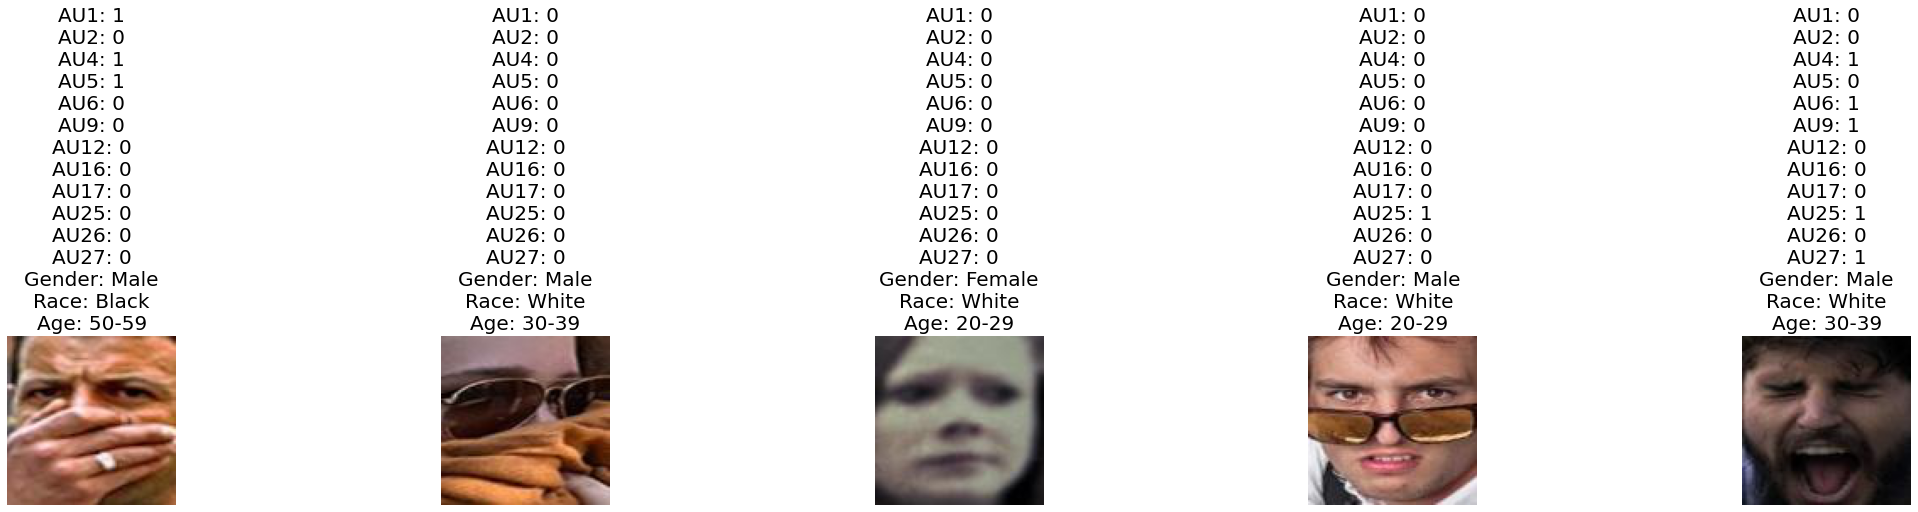

In [ ]:
num_images = 5
fig, axs = plt.subplots(figsize=(30, 7), ncols=num_images, constrained_layout=True)
for i in range(num_images):
  index = i+30
  image  =  mpimg.imread(df_rafau['face_name_align'][index])
  axs[i].imshow(image)  
  axs[i].set_title('AU1: {}\nAU2: {}\nAU4: {}\nAU5: {}\nAU6: {}\nAU9: {}\nAU12: {}\nAU16: {}\nAU17: {}\nAU25: {}\nAU26: {}\nAU27: {}\nGender: {}\nRace: {}\nAge: {}'.format(
      df_rafau[1][index],df_rafau[2][index],df_rafau[4][index],df_rafau[5][index],df_rafau[6][index],df_rafau[9][index],
      df_rafau[12][index],df_rafau[16][index],df_rafau[17][index],df_rafau[25][index],df_rafau[26][index],df_rafau[27][index],
      df_rafau['gender'][index],df_rafau['race'][index],df_rafau['age'][index]),fontsize = 20)
  axs[i].axis("off")

## data preprocessing 

In [ ]:
# load one image
image = Image.open(df_rafau['face_name_align'][122])
# convert image to numpy array
data = np.asarray(image)

In [ ]:
print(np.shape(data))

(100, 100, 3)


Οι εικόνες που στέλνουμε στο νευρωνικό δίκτυο είναι resized σε 100*100 και είναι έγχρωμες (τιμές απο 0-255). <br>
 Έτσι στο δίκτυο οι πίνακες είναι μεγέθους 100 * 100 * 3. 

Χωρίζω τα δεδομένα τυχαία μέχρι να βρώ ομοιες τιμές ratio σε train/validation/test

In [ ]:
df_train_val, df_test = train_test_split(df_rafau, test_size=0.30)
df_train, df_val = train_test_split(df_train_val, test_size=0.15)


print("Actiavated AU ratio for all sets")
data = []
ratio_train = []
ratio_val = []
ratio_test = []
aus = []
tt_diff = []
tv_diff = []
for au in final_aus:  
  aus.append(au)    
  r_train = len(df_train[df_train[au]==1])/(len(df_train))
  r_val = len(df_val[df_val[au]==1])/(len(df_val))
  r_test = len(df_test[df_test[au]==1])/(len(df_test))
  ratio_train.append(r_train)
  ratio_val.append(r_val)
  ratio_test.append(r_test)

  tt_diff.append(np.round(np.sum(np.square(r_train - r_test)),4))
  tv_diff.append(np.round(np.sum(np.square(r_train - r_val)),4))

table = zip(aus,ratio_train, ratio_val,ratio_test,tt_diff,tv_diff)
print(tabulate(table, headers=['AUs','train ratio','validation ratio','test ratio','train-test distance','train-val distance'], floatfmt=".4f"))




Actiavated AU ratio for all sets
  AUs    train ratio    validation ratio    test ratio    train-test distance    train-val distance
-----  -------------  ------------------  ------------  ---------------------  --------------------
    1         0.2325              0.2851        0.2217                 0.0001                0.0028
    2         0.1777              0.1950        0.1571                 0.0004                0.0003
    4         0.3880              0.3962        0.4170                 0.0008                0.0001
    5         0.2125              0.2474        0.1997                 0.0002                0.0012
    6         0.0981              0.0839        0.1021                 0.0000                0.0002
    9         0.1707              0.1719        0.1645                 0.0000                0.0000
   10         0.2995              0.3103        0.3069                 0.0001                0.0001
   12         0.2755              0.2600        0.2805             

In [ ]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [ ]:
#joblib.dump(df_train,'/content/gdrive/MyDrive/train_net/rafau/df_train')
#joblib.dump(df_test,'/content/gdrive/MyDrive/train_net/rafau/df_test')
#joblib.dump(df_val,'/content/gdrive/MyDrive/train_net/rafau/df_val')

df_train = joblib.load('/content/gdrive/MyDrive/train_net/rafau/df_train')
df_test = joblib.load('/content/gdrive/MyDrive/train_net/rafau/df_test')
df_val = joblib.load('/content/gdrive/MyDrive/train_net/rafau/df_val')


In [ ]:

#change type to float32
for i in final_aus:
  df_train[i] = df_train[i].astype('float32')
  df_val[i] = df_val[i].astype('float32')
  df_test[i] = df_test[i].astype('float32')

In [ ]:
# get batches of tensor image data (rescaled to 0-1)
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
    df_train,
    x_col='face_name_align',
    y_col=[1,2,4,5,6,9,10,12,16,17,25,26,27],
    target_size=(100, 100),
    color_mode='rgb',
    class_mode='raw', #multilabel output numpy array of values in y_col column(s),
    batch_size=batch_size 
  )

validation_generator = test_datagen.flow_from_dataframe(
    df_val,
    x_col="face_name_align",
    y_col=[1,2,4,5,6,9,10,12,16,17,25,26,27],
    target_size=(100, 100),
    color_mode='rgb',
    class_mode='raw',
    batch_size=batch_size
  )

test_generator = test_datagen.flow_from_dataframe(
    df_test,
    x_col="face_name_align",
    y_col=[1,2,4,5,6,9,10,12,16,17,25,26,27],
    target_size=(100, 100),
    color_mode='rgb',
    class_mode='raw',
    batch_size=batch_size,
    shuffle = False
  )


Found 2701 validated image filenames.
Found 477 validated image filenames.
Found 1362 validated image filenames.


## Class distribution

In [ ]:
print("Actiavated AU ratio for all sets before split")
data = []
ratio_train = []
ratio_val = []
ratio_test = []
aus = []
tt_diff = []
tv_diff = []
for au in final_aus:  
  aus.append(au)    
  r_train = len(df_train[df_train[au]==1])/(len(df_train))
  r_val = len(df_val[df_val[au]==1])/(len(df_val))
  r_test = len(df_test[df_test[au]==1])/(len(df_test))
  ratio_train.append(r_train)
  ratio_val.append(r_val)
  ratio_test.append(r_test)

  tt_diff.append(np.round(np.sum(np.square(r_train - r_test)),4))
  tv_diff.append(np.round(np.sum(np.square(r_train - r_val)),4))

table = zip(aus,ratio_train, ratio_val,ratio_test,tt_diff,tv_diff)
print(tabulate(table, headers=['AUs','train ratio','validation ratio','test ratio','train-test distance','train-val distance'], floatfmt=".4f"))

Actiavated AU ratio for all sets before split
  AUs    train ratio    validation ratio    test ratio    train-test distance    train-val distance
-----  -------------  ------------------  ------------  ---------------------  --------------------
    1         0.2410              0.2264        0.2254                 0.0002                0.0002
    2         0.1736              0.1698        0.1740                 0.0000                0.0000
    4         0.3899              0.4025        0.4112                 0.0005                0.0002
    5         0.2144              0.2096        0.2093                 0.0000                0.0000
    6         0.0966              0.1048        0.0977                 0.0000                0.0001
    9         0.1718              0.1509        0.1696                 0.0000                0.0004
   10         0.3058              0.3229        0.2900                 0.0002                0.0003
   12         0.2795              0.2683        0.2695

In [ ]:
def plot_samples(category,names,train_counter,val_counter,test_counter):
  fig, axs = plt.subplots(figsize=(20, 4), ncols=3, constrained_layout=True)
  sets = ['train','validation','test']
  for i,set_counter in enumerate([train_counter,val_counter,test_counter]):
    names_list = [name for name in names]
    axs[i].bar(names_list,set_counter,color='c',  edgecolor='black')
    axs[i].set_title("{} distribution for {} set".format(category,sets[i]),fontsize=15)

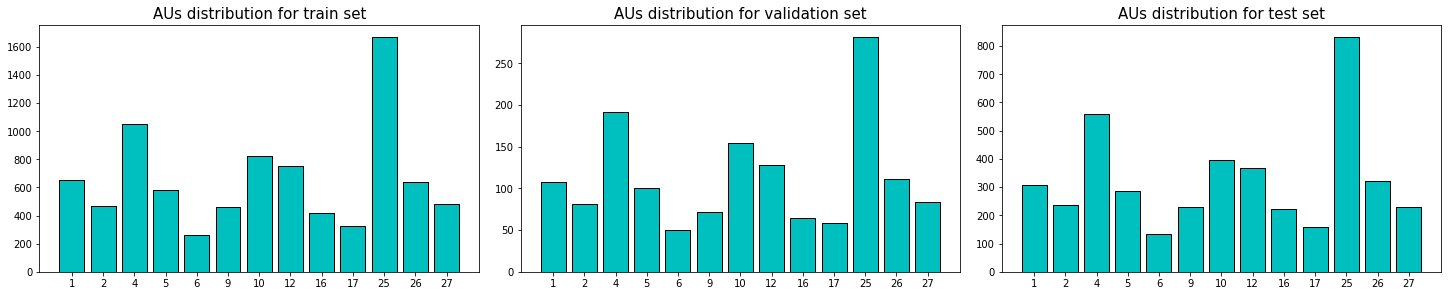

In [ ]:
final_aus_names = [str(au) for au in final_aus]


aus_count_train = []
for i in final_aus:
  aus_count_train.append(len(df_train[df_train[i]==1]))

aus_count_val = []
for i in final_aus:
  aus_count_val.append(len(df_val[df_val[i]==1]))

aus_count_test = []
for i in final_aus:
  aus_count_test.append(len(df_test[df_test[i]==1]))

plot_samples('AUs',final_aus_names,aus_count_train,aus_count_val,aus_count_test)


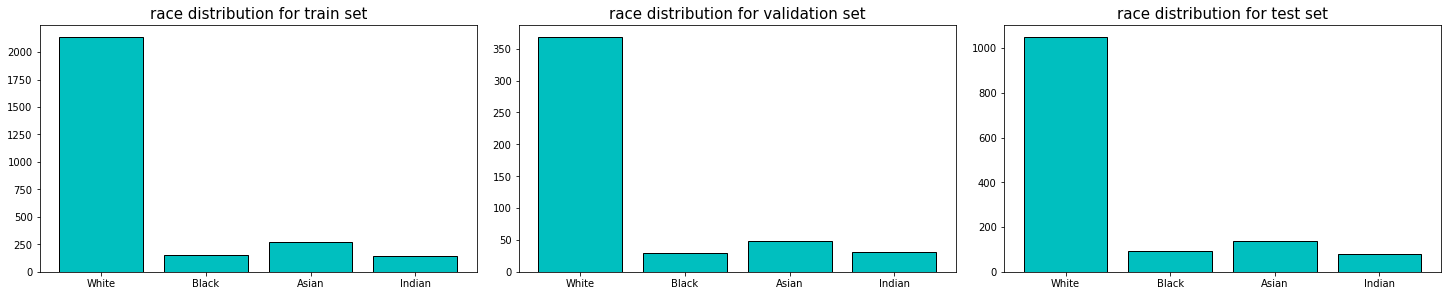

In [ ]:
race_names = ['White','Black','Asian','Indian']

race_counter_train = []
for i in range(len(race_names)):
  race_counter_train.append(len(df_train[df_train['race']==race_names[i]]))

race_counter_val = []
for i in range(len(race_names)):
  race_counter_val.append(len(df_val[df_val['race']==race_names[i]]))

race_counter_test = []
for i in range(len(race_names)):
  race_counter_test.append(len(df_test[df_test['race']==race_names[i]]))

plot_samples('race',race_names,race_counter_train,race_counter_val,race_counter_test)


In [ ]:
print(race_counter_train)
print(race_counter_val)
print(race_counter_test)

[2141, 150, 268, 142]
[369, 29, 48, 31]
[1051, 95, 137, 79]


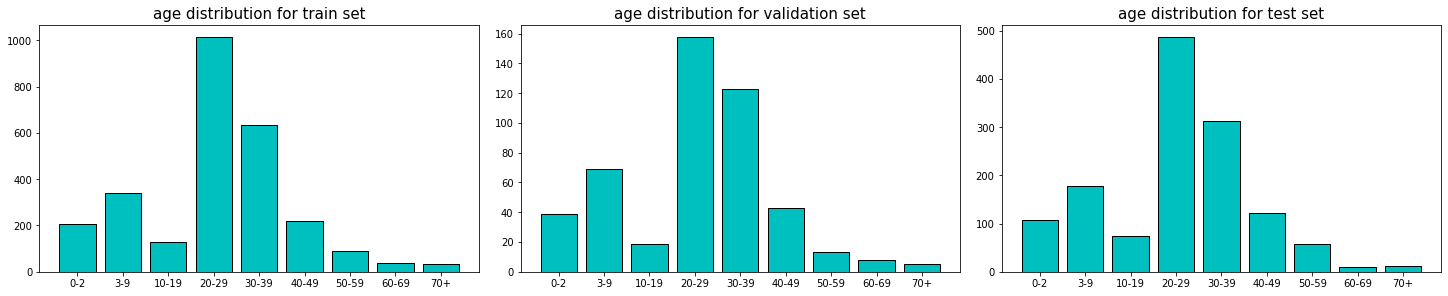

In [ ]:
age_names = ['0-2','3-9','10-19','20-29','30-39','40-49','50-59','60-69','70+']

age_counter_train = []
for i in range(len(age_names)):
  age_counter_train.append(len(df_train[df_train['age']==age_names[i]]))

age_counter_val = []
for i in range(len(age_names)):
  age_counter_val.append(len(df_val[df_val['age']==age_names[i]]))

age_counter_test = []
for i in range(len(age_names)):
  age_counter_test.append(len(df_test[df_test['age']==age_names[i]]))


plot_samples('age',age_names,age_counter_train,age_counter_val,age_counter_test)


In [ ]:
print(age_counter_train)
print(age_counter_val)
print(age_counter_test)

[206, 339, 128, 1016, 632, 221, 90, 37, 32]
[39, 69, 19, 158, 123, 43, 13, 8, 5]
[107, 177, 75, 488, 313, 121, 58, 10, 13]


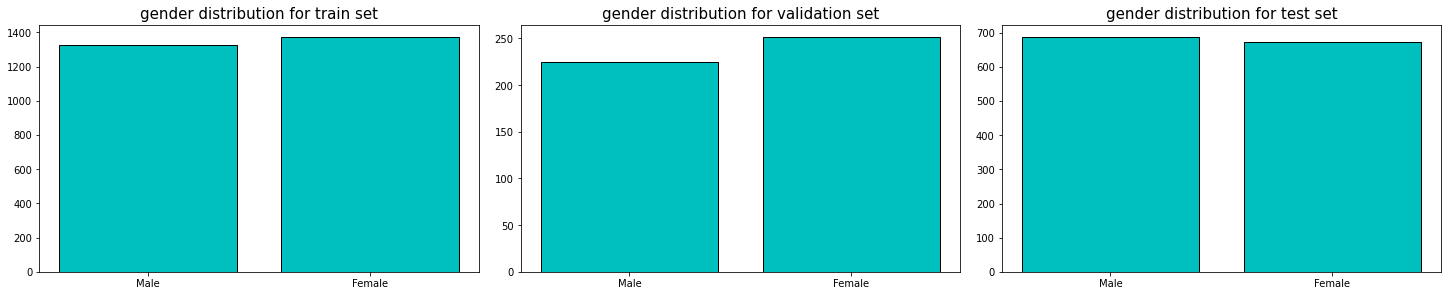

In [ ]:
gender_names = ['Male','Female']

gender_counter_train = []
for i in range(len(gender_names)):
  gender_counter_train.append(len(df_train[df_train['gender']==gender_names[i]]))

gender_counter_val = []
for i in range(len(gender_names)):
  gender_counter_val.append(len(df_val[df_val['gender']==gender_names[i]]))

gender_counter_test = []
for i in range(len(gender_names)):
  gender_counter_test.append(len(df_test[df_test['gender']==gender_names[i]]))

plot_samples('gender',gender_names,gender_counter_train,gender_counter_val,gender_counter_test)


In [ ]:
print(gender_counter_train)
print(gender_counter_val)
print(gender_counter_test)

[1325, 1376]
[225, 252]
[689, 673]


## training

Multilabel binary classification problem <br>
 

In [ ]:
#our model
resnet_model = Sequential()

#pretrained model
pretrained_model= tf.keras.applications.ResNet50(
    include_top=False, #custume input and output layers based on our data
    weights="imagenet", #use weights from imagenet training 
    input_tensor=None,
    input_shape=(100,100,3),
    pooling='avg' , #average
)
     
resnet_model.add(pretrained_model)

94781440/94765736 [==============================] - 0s 0us/step


In [ ]:
# see layers of resnet 50
#pretrained_model.summary()

In [ ]:

resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(13, activation='sigmoid')) 


In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 13)                6669      
                                                                 
Total params: 24,643,469
Trainable params: 24,590,349
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
#compile model
resnet_model.compile(optimizer=Adam(learning_rate=0.001),
                     loss=tf.keras.losses.BinaryCrossentropy())

In [ ]:
#checkpoint 
filepath = "/content/gdrive/MyDrive/train_net/ckp_models/RAFAU/RAFAU_NO/RAFAU_before/RAFAU-{epoch:02d}.h5"
checkpoint = ModelCheckpoint(  
    filepath,
    monitor="val_loss",
    verbose=1,
    save_best_only=False,
    save_weights_only=False,
    mode="auto",
    save_freq="epoch")

callbacks_list = [checkpoint]


#fit model
history = resnet_model.fit(train_generator,validation_data=validation_generator,epochs=10,callbacks=callbacks_list)


Epoch 1/10
85/85 [==============================] - ETA: 0s - loss: 0.0695
Epoch 1: saving model to /content/gdrive/MyDrive/train_net/ckp_models/RAFAU/RAFAU_NO/RAFAU_before/RAFAU-01.h5
85/85 [==============================] - 15s 170ms/step - loss: 0.0695 - val_loss: 0.4732
Epoch 2/10
85/85 [==============================] - ETA: 0s - loss: 0.0576
Epoch 2: saving model to /content/gdrive/MyDrive/train_net/ckp_models/RAFAU/RAFAU_NO/RAFAU_before/RAFAU-02.h5
85/85 [==============================] - 16s 193ms/step - loss: 0.0576 - val_loss: 0.5679
Epoch 3/10
85/85 [==============================] - ETA: 0s - loss: 0.0535
Epoch 3: saving model to /content/gdrive/MyDrive/train_net/ckp_models/RAFAU/RAFAU_NO/RAFAU_before/RAFAU-03.h5
85/85 [==============================] - 14s 167ms/step - loss: 0.0535 - val_loss: 0.6216
Epoch 4/10
85/85 [==============================] - ETA: 0s - loss: 0.0433
Epoch 4: saving model to /content/gdrive/MyDrive/train_net/ckp_models/RAFAU/RAFAU_NO/RAFAU_before/RA

## evaluation & threshold
 

In [ ]:
#return list of predictions based on threshold
def threshold_predictions(predictions,thr):
  y_pred = [1 if i>=thr else 0 for i in predictions]
  return y_pred
  

In [ ]:
# calculates transformed predictions and returns mean of macro f1 score for all labels/prediction sets 
def macro_f1(labels,predictions,thr):
  predictions_thr =threshold_predictions(predictions,thr)
  f1 = f1_score(labels,predictions_thr,average='binary')
  return f1


In [ ]:
# calculates eachf1 & returns mean of all 13 f1 scores
def mean_macro_f1(aus_labels,aus_predictions,thr,print=False):
  f1_all = []
  if print==True: print("f1 score for each AU")
  for au in range(1,14):
    f1 = macro_f1(aus_labels[au],aus_predictions[au],thr)
    if print==True:print('AU {} --> F1 {} '.format(au, f1))
    f1_all.append(f1)
  if print==True:print("mean f1 score for all AUs:",statistics.mean(f1_all))
  return (statistics.mean(f1_all))


In [ ]:
# dictionaries with keys   -- > AUs (13)
#                   values -- > labels/predictions of AU (len(test_images))

def labels_predictions_aus(labels,predictions):
  aus_labels = {k: [] for k in range(1,14)}
  aus_predictions =  {k: [] for k in range(1,14)}

  for l,p in zip(labels,predictions):
    for au in range(1,14):
      aus_labels[au].append(l[au-1])
      aus_predictions[au].append(p[au-1])
  return(aus_labels,aus_predictions)




In [ ]:
# return labels and predictions for each category
def labels_predictions__category(df_test,test_generator,labels,predictions,category_list,category_name):
  labels_cat = {key: [] for key in category_list}
  predictions_cat = {key: [] for key in category_list}
  category_counter = {key: [] for key in category_list} # values are list of indexes of each category

  for i,name in enumerate(test_generator.filenames):  
    category_filename = df_test.loc[df_test['face_name_align'] == name, category_name].item()
    for cat in category_list:
      if category_filename == cat:
          category_counter[cat].append(i)
          labels_cat[cat].append(labels[i])
          predictions_cat[cat].append(predictions[i])
        
    
  return labels_cat,predictions_cat,category_counter

In [ ]:
# calculates and shows results
def results_category(split,category_list,category_name,y_true,y_pred,thr,category_counter):
  print("{} scores {} split".format(category_name,split))
  data = []
  for cat in category_list:
    aus_labels_cat,aus_predictions_cat = labels_predictions_aus(y_true[cat],y_pred[cat])
    data.append([cat,len(category_counter[cat]), mean_macro_f1(aus_labels_cat,aus_predictions_cat,thr)])
  print(tabulate(data, headers=[category_name,"#images" ,"mean macro f1 score"]))
  print()



In [ ]:
models_labels = {}
models_predictions = {}
models_directory = '/content/gdrive/MyDrive/train_net/ckp_models/RAFAU/RAFAU_NO/RAFAU_before'
for saved_model in (os.listdir(models_directory)):
  print(saved_model)
  model = tf.keras.models.load_model(os.path.join(models_directory,saved_model))
  models_labels[saved_model[:-3]] = test_generator.labels
  models_predictions[saved_model[:-3]] = model.predict(test_generator)


RAFAU-08.h5


In [ ]:
for model_name in models_labels.keys():
  aus_labels,aus_predictions = labels_predictions_aus(models_labels[model_name],models_predictions[model_name])
  print("Model Name: =",model_name)
  for thr in np.arange(0,1.1,0.1):
    mean_f1 = mean_macro_f1(aus_labels,aus_predictions,thr)
    print(" Threshold: {} F1 score: {}".format(np.round(thr,2),np.round(mean_f1,4)))


Model Name: = RAFAU-08
 Threshold: 0.0 F1 score: 0.3738
 Threshold: 0.1 F1 score: 0.665
 Threshold: 0.2 F1 score: 0.6632
 Threshold: 0.3 F1 score: 0.6558
 Threshold: 0.4 F1 score: 0.6499
 Threshold: 0.5 F1 score: 0.6412
 Threshold: 0.6 F1 score: 0.6297
 Threshold: 0.7 F1 score: 0.6206
 Threshold: 0.8 F1 score: 0.605
 Threshold: 0.9 F1 score: 0.5734
 Threshold: 1.0 F1 score: 0.009


In [ ]:
best_model_name = 'RAFAU-08'
best_model = tf.keras.models.load_model(os.path.join(models_directory,"{}.h5".format(best_model_name)))
best_threshold = 0.1

In [ ]:
RACES =['White','Black','Asian','Indian']
y_true_race,y_pred_race,counter_race = labels_predictions__category(df_test,test_generator,models_labels[best_model_name],models_predictions[best_model_name],RACES,'race')

GENDERS = ['Male','Female']
y_true_gender,y_pred_gender,counter_gender = labels_predictions__category(df_test,test_generator,models_labels[best_model_name],models_predictions[best_model_name],GENDERS,'gender')

AGES = ['0-2','3-9','10-19','20-29','30-39','40-49','50-59','60-69','70+']
y_true_age,y_pred_age,counter_age = labels_predictions__category(df_test,test_generator,models_labels[best_model_name],models_predictions[best_model_name],AGES,'age')



In [ ]:
import warnings
warnings.filterwarnings("ignore") 

In [ ]:
print("RAF-AU")
print("NO AUG")
print("BEFORE split")
aus_labels_best, aus_predictions_best = labels_predictions_aus(models_labels[best_model_name],models_predictions[best_model_name])
data = [[mean_macro_f1(aus_labels_best,aus_predictions_best,best_threshold)]]
print(tabulate(data, headers=[" macro f1 score"]))
print()
results_category('before',RACES,'race',y_true_race,y_pred_race,best_threshold,counter_race)
results_category('before',GENDERS,'gender',y_true_gender,y_pred_gender,best_threshold,counter_gender)
results_category('before',AGES,'age',y_true_age,y_pred_age,best_threshold,counter_age)


RAF-AU
NO AUG
BEFORE split
   macro f1 score
-----------------
         0.665002

race scores before split
race      #images    mean macro f1 score
------  ---------  ---------------------
White        1051               0.670032
Black          95               0.67136
Asian         137               0.663112
Indian         79               0.512878

gender scores before split
gender      #images    mean macro f1 score
--------  ---------  ---------------------
Male            689               0.680924
Female          673               0.64214

age scores before split
age      #images    mean macro f1 score
-----  ---------  ---------------------
0-2          107               0.557621
3-9          177               0.647631
10-19         75               0.556265
20-29        488               0.673585
30-39        313               0.671623
40-49        121               0.668937
50-59         58               0.720368
60-69         10               0.716667
70+           13        

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


## Visualize predictions

In [ ]:
print("Labels and Predictions for one batch")
X,y = test_generator.next()
prediction_show = best_model.predict(X)
for i in range(batch_size):
  labels = np.array([int(num) for num in y[i]])
  print("truth:      {}\nprediction: {} ".format(labels,np.array(threshold_predictions((prediction_show[i]),best_threshold))))


Labels and Predictions for one batch
truth:      [0 0 0 1 0 0 0 1 0 0 1 0 0]
prediction: [0 0 0 1 0 0 0 1 0 0 1 0 0] 
truth:      [1 1 0 0 0 0 0 0 0 0 1 1 0]
prediction: [1 0 0 0 0 0 0 0 0 0 1 0 0] 
truth:      [0 0 1 0 0 0 1 0 0 1 0 0 0]
prediction: [0 0 1 0 0 0 0 0 0 0 0 0 0] 
truth:      [0 0 0 0 1 0 1 1 0 0 1 0 0]
prediction: [1 0 0 0 0 0 1 1 1 0 1 0 0] 
truth:      [1 1 0 0 0 0 0 0 0 1 0 0 0]
prediction: [1 0 0 0 0 0 0 0 0 1 0 0 0] 
truth:      [0 0 1 0 0 0 1 0 0 1 0 0 0]
prediction: [0 0 1 0 0 0 0 0 0 0 0 0 0] 
truth:      [0 0 0 1 0 0 0 0 0 0 1 1 0]
prediction: [0 0 0 0 0 0 0 0 1 0 1 1 0] 
truth:      [0 0 1 0 0 0 1 0 0 0 1 1 0]
prediction: [0 0 0 0 0 0 1 1 0 0 1 1 0] 
truth:      [0 0 1 0 1 1 0 1 1 0 1 0 1]
prediction: [0 0 1 0 0 0 1 0 1 0 1 0 1] 
truth:      [1 0 1 0 0 0 0 0 0 0 0 0 0]
prediction: [1 0 1 0 0 0 0 1 0 0 0 0 0] 
truth:      [1 0 1 0 0 0 0 0 0 1 0 0 0]
prediction: [1 0 1 0 0 0 0 0 0 1 0 0 0] 
truth:      [0 0 1 1 0 0 0 0 0 0 1 0 0]
prediction: [0 0 1 0 0 0 0 0 0 0

# after split

In [ ]:
GENDERS = ['Male','Female']
RACES =['White','Black','Asian','Indian']
AGES = ['0-2','3-9','10-19','20-29','30-39','40-49','50-59','60-69','70+']

In [ ]:
def train_val_test_split(category):
  len_list = len(category)
  train_per = int(len_list*0.55)
  val_per = int(len_list*0.15)
  test_per = int(len_list*0.30)
  
  train_category = list(category['face_name_align'][:train_per])
  val_category = list(category['face_name_align'][train_per:train_per+val_per])
  test_category = list(category['face_name_align'][train_per+val_per:])

  return train_category,val_category,test_category


In [ ]:
train_new = []
validation_new = []
test_new = []

for gender in GENDERS:
  for race in RACES:
    for age in AGES:
      print("gender:",gender,"race:",race,"age:",age)
      df_category = df_rafau[(df_rafau['gender']==gender) & (df_rafau['race']==race) & (df_rafau['age']==age)]      
      train_c,val_c,test_c = train_val_test_split(df_category)
      train_new.append(train_c)
      validation_new.append(val_c)
      test_new.append(test_c)
      

gender: Male race: White age: 0-2
gender: Male race: White age: 3-9
gender: Male race: White age: 10-19
gender: Male race: White age: 20-29
gender: Male race: White age: 30-39
gender: Male race: White age: 40-49
gender: Male race: White age: 50-59
gender: Male race: White age: 60-69
gender: Male race: White age: 70+
gender: Male race: Black age: 0-2
gender: Male race: Black age: 3-9
gender: Male race: Black age: 10-19
gender: Male race: Black age: 20-29
gender: Male race: Black age: 30-39
gender: Male race: Black age: 40-49
gender: Male race: Black age: 50-59
gender: Male race: Black age: 60-69
gender: Male race: Black age: 70+
gender: Male race: Asian age: 0-2
gender: Male race: Asian age: 3-9
gender: Male race: Asian age: 10-19
gender: Male race: Asian age: 20-29
gender: Male race: Asian age: 30-39
gender: Male race: Asian age: 40-49
gender: Male race: Asian age: 50-59
gender: Male race: Asian age: 60-69
gender: Male race: Asian age: 70+
gender: Male race: Indian age: 0-2
gender: Mal

In [ ]:
train_list = list(np.concatenate(train_new).flat)
validation_list = list(np.concatenate(validation_new).flat)
test_list = list(np.concatenate(test_new).flat)


In [ ]:
len(train_list)+len(validation_list)+len(test_list)

4540

In [ ]:
df_train_fair = df_rafau[df_rafau['face_name_align'].isin(train_list)]
df_validation_fair = df_rafau[df_rafau['face_name_align'].isin(validation_list)]
df_test_fair = df_rafau[df_rafau['face_name_align'].isin(test_list)]

##Show data

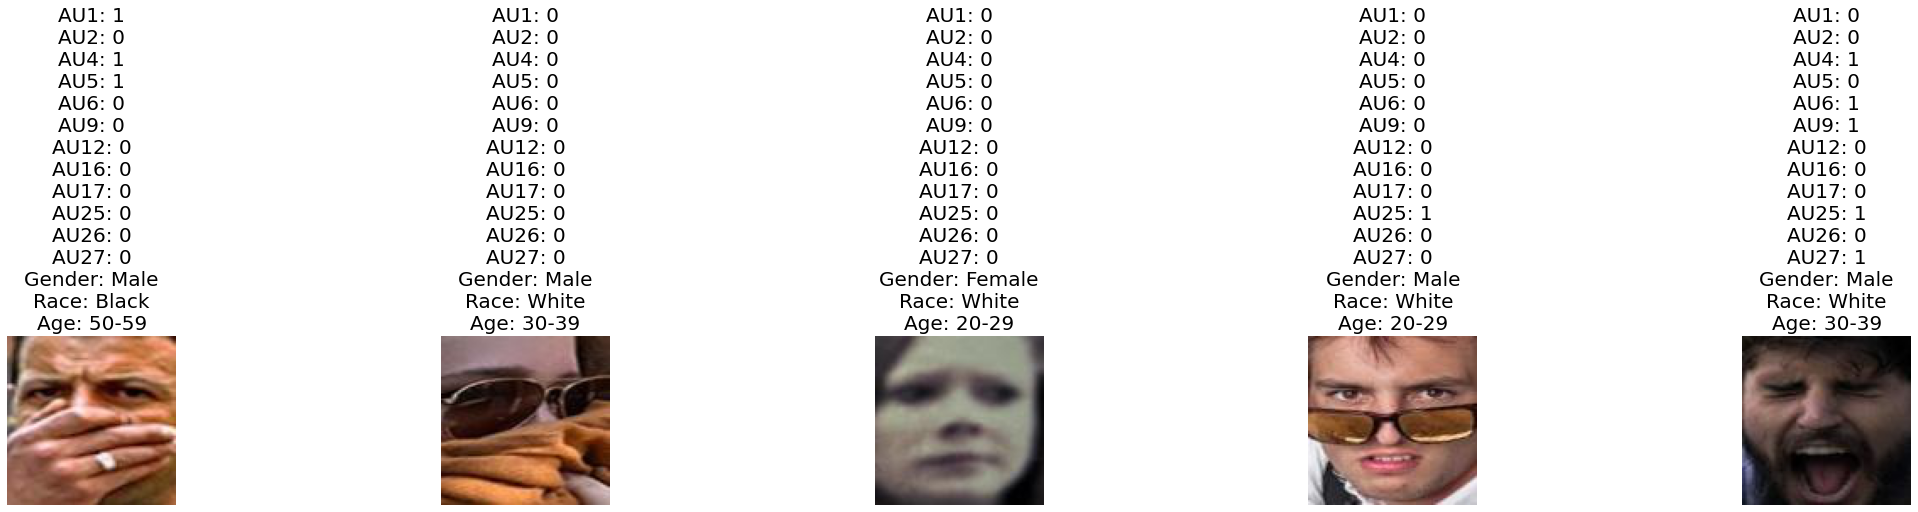

In [ ]:
num_images = 5
fig, axs = plt.subplots(figsize=(30, 7), ncols=num_images, constrained_layout=True)
for i in range(num_images):
  index = i+30
  image  =  mpimg.imread(df_train_fair['face_name_align'][index])
  axs[i].imshow(image)  
  axs[i].set_title('AU1: {}\nAU2: {}\nAU4: {}\nAU5: {}\nAU6: {}\nAU9: {}\nAU12: {}\nAU16: {}\nAU17: {}\nAU25: {}\nAU26: {}\nAU27: {}\nGender: {}\nRace: {}\nAge: {}'.format(
      df_train_fair[1][index],df_train_fair[2][index],df_train_fair[4][index],df_train_fair[5][index],df_train_fair[6][index],df_train_fair[9][index],
      df_train_fair[12][index],df_train_fair[16][index],df_train_fair[17][index],df_train_fair[25][index],df_train_fair[26][index],df_train_fair[27][index],
      df_train_fair['gender'][index],df_train_fair['race'][index],df_train_fair['age'][index]),fontsize = 20)
  axs[i].axis("off")

## data preprocessing 

In [ ]:
# load one image
image = Image.open(df_train_fair['face_name_align'][122])
# convert image to numpy array
data = np.asarray(image)

In [ ]:
print(np.shape(data))

(100, 100, 3)


Οι εικόνες που στέλνουμε στο νευρωνικό δίκτυο είναι resized σε 100*100 και είναι έγχρωμες (τιμές απο 0-255). <br>
 Έτσι στο δίκτυο οι πίνακες είναι μεγέθους 100 * 100 * 3. 

In [ ]:
# get batches of tensor image data (rescaled to 0-1)
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
for i in final_aus:
  df_train_fair[i] = df_train_fair[i].astype('float32')
  df_validation_fair[i] = df_validation_fair[i].astype('float32')
  df_test_fair[i] = df_test_fair[i].astype('float32')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [ ]:
df_train_fair

,face_name_align,1,2,4,5,6,9,10,12,16,17,25,26,27,race,gender,age
0,/content/gdrive/MyDrive/train_net/datasets/raf...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,Asian,Female,70+
1,/content/gdrive/MyDrive/train_net/datasets/raf...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,Asian,Female,30-39
2,/content/gdrive/MyDrive/train_net/datasets/raf...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,White,Female,20-29
3,/content/gdrive/MyDrive/train_net/datasets/raf...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,White,Female,20-29
4,/content/gdrive/MyDrive/train_net/datasets/raf...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,White,Male,30-39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3372,/content/gdrive/MyDrive/train_net/datasets/raf...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Black,Male,30-39
3396,/content/gdrive/MyDrive/train_net/datasets/raf...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,Black,Male,30-39
3403,/content/gdrive/MyDrive/train_net/datasets/raf...,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,Black,Male,20-29
3441,/content/gdrive/MyDrive/train_net/datasets/raf...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,Black,Female,30-39


In [ ]:
batch_size = 32

train_generator_fair = train_datagen.flow_from_dataframe(
    df_train_fair,
    x_col='face_name_align',
    y_col=[1,2,4,5,6,9,10,12,16,17,25,26,27],
    target_size=(100, 100),
    color_mode='rgb',
    class_mode='raw', #multilabel output numpy array of values in y_col column(s),
    batch_size=batch_size 
  )

validation_generator_fair = test_datagen.flow_from_dataframe(
    df_validation_fair,
    x_col="face_name_align",
    y_col=[1,2,4,5,6,9,10,12,16,17,25,26,27],
    target_size=(100, 100),
    color_mode='rgb',
    class_mode='raw',
    batch_size=batch_size
  )

test_generator_fair = test_datagen.flow_from_dataframe(
    df_test_fair,
    x_col="face_name_align",
    y_col=[1,2,4,5,6,9,10,12,16,17,25,26,27],
    target_size=(100, 100),
    color_mode='rgb',
    class_mode='raw',
    batch_size=batch_size,
    shuffle=False
  )


Found 2469 validated image filenames.
Found 645 validated image filenames.
Found 1426 validated image filenames.


## Class distribution

In [ ]:
print("Actiavated AU ratio for all sets after split")
data = []
ratio_train = []
ratio_val = []
ratio_test = []
aus = []
tt_diff = []
tv_diff = []
for au in final_aus:  
  aus.append(au)    
  r_train = len(df_train_fair[df_train_fair[au]==1])/(len(df_train_fair))
  r_val = len(df_validation_fair[df_validation_fair[au]==1])/(len(df_validation_fair))
  r_test = len(df_test_fair[df_test_fair[au]==1])/(len(df_test_fair))
  ratio_train.append(r_train)
  ratio_val.append(r_val)
  ratio_test.append(r_test)

  tt_diff.append(np.round(np.sum(np.square(r_train - r_test)),4))
  tv_diff.append(np.round(np.sum(np.square(r_train - r_val)),4))

table = zip(aus,ratio_train, ratio_val,ratio_test,tt_diff,tv_diff)
print(tabulate(table, headers=['AUs','train ratio','validation ratio','test ratio','train-test distance','train-val distance'], floatfmt=".4f"))




Actiavated AU ratio for all sets after split
  AUs    train ratio    validation ratio    test ratio    train-test distance    train-val distance
-----  -------------  ------------------  ------------  ---------------------  --------------------
    1         0.2410              0.2543        0.2153                 0.0007                0.0002
    2         0.1669              0.1876        0.1781                 0.0001                0.0004
    4         0.4026              0.3643        0.4039                 0.0000                0.0015
    5         0.2426              0.2171        0.1578                 0.0072                0.0007
    6         0.0883              0.0930        0.1164                 0.0008                0.0000
    9         0.1559              0.1364        0.2062                 0.0025                0.0004
   10         0.2677              0.3178        0.3569                 0.0080                0.0025
   12         0.2365              0.2760        0.3422 

In [ ]:
def plot_samples(category,names,train_counter,val_counter,test_counter):
  fig, axs = plt.subplots(figsize=(20, 4), ncols=3, constrained_layout=True)
  sets = ['train','validation','test']
  for i,set_counter in enumerate([train_counter,val_counter,test_counter]):
    names_list = [name for name in names]
    axs[i].bar(names_list,set_counter,color='c',  edgecolor='black')
    axs[i].set_title("{} distribution for {} set".format(category,sets[i]),fontsize=15)

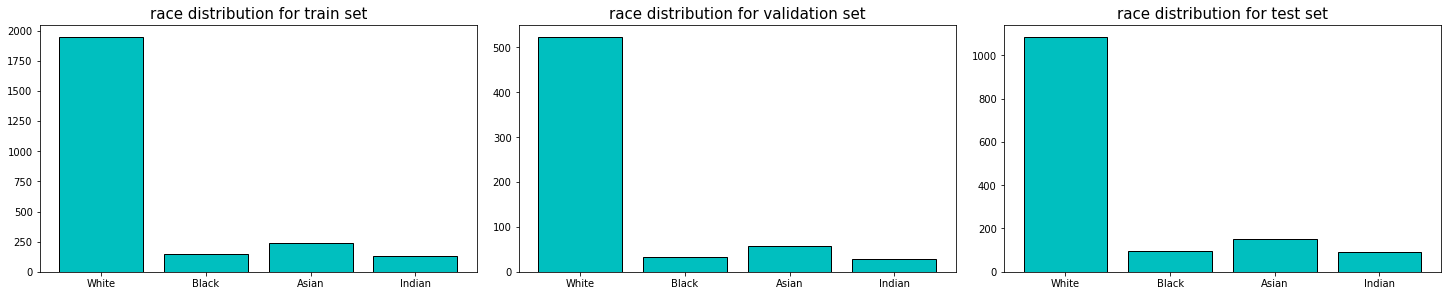

In [ ]:
race_names = ['White','Black','Asian','Indian']

race_counter_train = []
for i in range(len(race_names)):
  race_counter_train.append(len(df_train_fair[df_train_fair['race']==race_names[i]]))

race_counter_val = []
for i in range(len(race_names)):
  race_counter_val.append(len(df_validation_fair[df_validation_fair['race']==race_names[i]]))

race_counter_test = []
for i in range(len(race_names)):
  race_counter_test.append(len(df_test_fair[df_test_fair['race']==race_names[i]]))

plot_samples('race',race_names,race_counter_train,race_counter_val,race_counter_test)


In [ ]:
print(race_counter_train)
print(race_counter_val)
print(race_counter_test)

[1951, 144, 243, 131]
[524, 34, 58, 29]
[1086, 96, 152, 92]


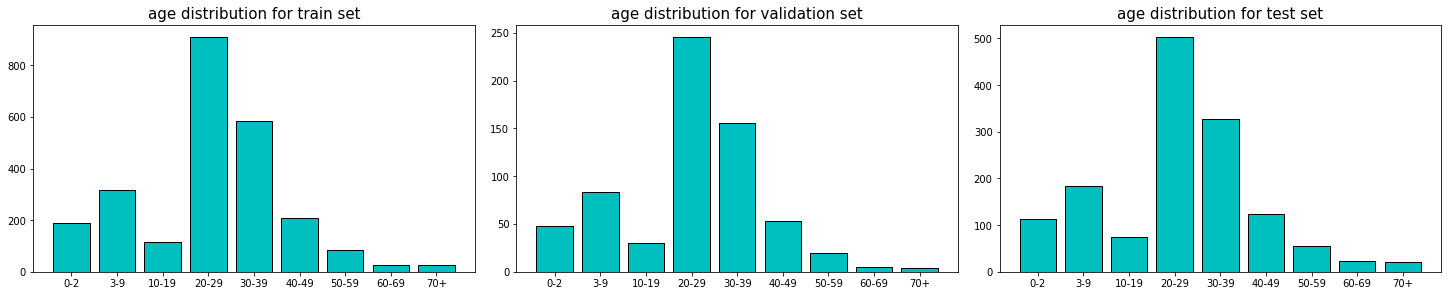

In [ ]:
age_names = ['0-2','3-9','10-19','20-29','30-39','40-49','50-59','60-69','70+']

age_counter_train = []
for i in range(len(age_names)):
  age_counter_train.append(len(df_train_fair[df_train_fair['age']==age_names[i]]))

age_counter_val = []
for i in range(len(age_names)):
  age_counter_val.append(len(df_validation_fair[df_validation_fair['age']==age_names[i]]))

age_counter_test = []
for i in range(len(age_names)):
  age_counter_test.append(len(df_test_fair[df_test_fair['age']==age_names[i]]))

plot_samples('age',age_names,age_counter_train,age_counter_val,age_counter_test)


In [ ]:
print(age_counter_train)
print(age_counter_val)
print(age_counter_test)

[191, 318, 117, 912, 584, 208, 86, 27, 26]
[48, 83, 30, 246, 156, 53, 20, 5, 4]
[113, 184, 75, 504, 328, 124, 55, 23, 20]


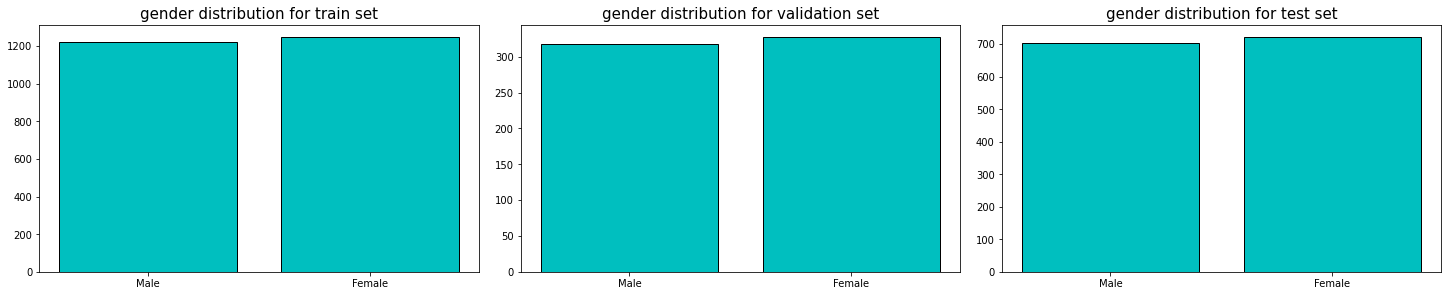

In [ ]:
gender_names = ['Male','Female']

gender_counter_train = []
for i in range(len(gender_names)):
  gender_counter_train.append(len(df_train_fair[df_train_fair['gender']==gender_names[i]]))

gender_counter_val = []
gender_names =  ['Male','Female']
for i in range(len(gender_names)):
  gender_counter_val.append(len(df_validation_fair[df_validation_fair['gender']==gender_names[i]]))

gender_counter_test = []
gender_names =  ['Male','Female']
for i in range(len(gender_names)):
  gender_counter_test.append(len(df_test_fair[df_test_fair['gender']==gender_names[i]]))

plot_samples('gender',gender_names,gender_counter_train,gender_counter_val,gender_counter_test)


In [ ]:
print(gender_counter_train)
print(gender_counter_val)
print(gender_counter_test)

[1219, 1250]
[317, 328]
[703, 723]


## training

Multilabel binary classification problem <br>
 

In [ ]:
#our model
resnet_model_fair = Sequential()

#pretrained model
pretrained_model= tf.keras.applications.ResNet50(
    include_top=False, #custume input and output layers based on our data
    weights="imagenet", #use weights from imagenet training 
    input_tensor=None,
    input_shape=(100,100,3),
    pooling='avg' , #average
)
     
resnet_model_fair.add(pretrained_model)

In [ ]:
# see layers of resnet 50
#pretrained_model.summary()

In [ ]:
resnet_model_fair.add(Dense(512, activation='relu'))
resnet_model_fair.add(Dense(13, activation='sigmoid')) #sigmoid


In [ ]:
resnet_model_fair.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_4 (Dense)             (None, 512)               1049088   
                                                                 
 dense_5 (Dense)             (None, 13)                6669      
                                                                 
Total params: 24,643,469
Trainable params: 24,590,349
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
#compile model
resnet_model_fair.compile(optimizer=Adam(learning_rate=0.001),
                     loss=tf.keras.losses.BinaryCrossentropy())

In [ ]:
#checkpoint 
filepath = "/content/gdrive/MyDrive/train_net/ckp_models/RAFAU/RAFAU_NO/RAFAU_after/RAFAU-{epoch:02d}.h5"
checkpoint = ModelCheckpoint(  
    filepath,
    monitor="val_loss",
    verbose=1,
    save_best_only=False,
    save_weights_only=False,
    mode="auto",
    save_freq="epoch")

callbacks_list = [checkpoint]


#fit model
history = resnet_model_fair.fit(train_generator_fair,validation_data=validation_generator_fair,epochs=10,callbacks=callbacks_list)


Epoch 1/10
78/78 [==============================] - ETA: 0s - loss: 0.4249
Epoch 1: saving model to /content/gdrive/MyDrive/train_net/ckp_models/RAFAU/RAFAU_NO/RAFAU_after/RAFAU-01.h5
78/78 [==============================] - 19s 182ms/step - loss: 0.4249 - val_loss: 1.1979
Epoch 2/10
78/78 [==============================] - ETA: 0s - loss: 0.3313
Epoch 2: saving model to /content/gdrive/MyDrive/train_net/ckp_models/RAFAU/RAFAU_NO/RAFAU_after/RAFAU-02.h5
78/78 [==============================] - 13s 161ms/step - loss: 0.3313 - val_loss: 0.5408
Epoch 3/10
78/78 [==============================] - ETA: 0s - loss: 0.2902
Epoch 3: saving model to /content/gdrive/MyDrive/train_net/ckp_models/RAFAU/RAFAU_NO/RAFAU_after/RAFAU-03.h5
78/78 [==============================] - 12s 155ms/step - loss: 0.2902 - val_loss: 0.5552
Epoch 4/10
78/78 [==============================] - ETA: 0s - loss: 0.2517
Epoch 4: saving model to /content/gdrive/MyDrive/train_net/ckp_models/RAFAU/RAFAU_NO/RAFAU_after/RAFAU-

## evaluation & threshold
 

In [ ]:
models_labels_fair = {}
models_predictions_fair = {}
models_directory_fair = '/content/gdrive/MyDrive/train_net/ckp_models/RAFAU/RAFAU_NO/RAFAU_after'
for saved_model in (os.listdir(models_directory_fair)):
  model = tf.keras.models.load_model(os.path.join(models_directory_fair,saved_model))
  models_labels_fair[saved_model[:-3]] = test_generator_fair.labels
  models_predictions_fair[saved_model[:-3]] = model.predict(test_generator_fair)


In [ ]:
for model_name in models_labels_fair.keys():
  aus_labels_fair,aus_predictions_fair = labels_predictions_aus(models_labels_fair[model_name],models_predictions_fair[model_name])
  print("Model Name: =",model_name)
  for thr in np.arange(0,1.1,0.1):
    mean_f1 = mean_macro_f1(aus_labels_fair,aus_predictions_fair,thr)
    print(" Threshold: {} F1 score: {}".format(np.round(thr,2),np.round(mean_f1,4)))


Model Name: = RAFAU-10
 Threshold: 0.0 F1 score: 0.3942
 Threshold: 0.1 F1 score: 0.5372
 Threshold: 0.2 F1 score: 0.5267
 Threshold: 0.3 F1 score: 0.5006
 Threshold: 0.4 F1 score: 0.4808
 Threshold: 0.5 F1 score: 0.4562
 Threshold: 0.6 F1 score: 0.4308
 Threshold: 0.7 F1 score: 0.4019
 Threshold: 0.8 F1 score: 0.3697
 Threshold: 0.9 F1 score: 0.3157
 Threshold: 1.0 F1 score: 0.0


In [ ]:
best_model_name_fair = 'RAFAU-10'
best_model_fair = tf.keras.models.load_model(os.path.join(models_directory_fair,"{}.h5".format(best_model_name_fair)))
best_threshold_fair = 0.1

In [ ]:
# labels&predictions for each category
RACES =['White','Black','Asian','Indian']
y_true_race_fair,y_pred_race_fair,counter_race_fair = labels_predictions__category(df_test_fair,test_generator_fair,
                                                                 models_labels_fair[best_model_name_fair],models_predictions_fair[best_model_name_fair],
                                                                 RACES,'race')

GENDERS = ['Male','Female']
y_true_gender_fair,y_pred_gender_fair,counter_gender_fair = labels_predictions__category(df_test_fair,test_generator_fair,
                                                           models_labels_fair[best_model_name_fair],models_predictions_fair[best_model_name_fair],
                                                           GENDERS,'gender')

AGES = ['0-2','3-9','10-19','20-29','30-39','40-49','50-59','60-69','70+']
y_true_age_fair,y_pred_age_fair,counter_age_fair = labels_predictions__category(df_test_fair,test_generator_fair,
                                                     models_labels_fair[best_model_name_fair],models_predictions_fair[best_model_name_fair],
                                                     AGES,'age')



In [ ]:
import warnings
warnings.filterwarnings("ignore") 

In [ ]:
print("RAF-AU")
print("NO AUG")
print("AFTER split")
aus_labels_best_fair, aus_predictions_best_fair = labels_predictions_aus(models_labels_fair[best_model_name_fair],models_predictions_fair[best_model_name_fair])
data = [[mean_macro_f1(aus_labels_best_fair,aus_predictions_best_fair,best_threshold_fair)]]
print(tabulate(data, headers=[" macro f1 score"]))
print()
results_category('after',RACES,'race',y_true_race_fair,y_pred_race_fair,best_threshold_fair,counter_race_fair)
results_category('after',GENDERS,'gender',y_true_gender_fair,y_pred_gender_fair,best_threshold_fair,counter_gender_fair)
results_category('after',AGES,'age',y_true_age_fair,y_pred_age_fair,best_threshold_fair,counter_age_fair)


RAF-AU
NO AUG
AFTER split
   macro f1 score
-----------------
         0.537155

race scores after split
race      #images    mean macro f1 score
------  ---------  ---------------------
White        1086               0.541114
Black          96               0.515006
Asian         152               0.553268
Indian         92               0.428028

gender scores after split
gender      #images    mean macro f1 score
--------  ---------  ---------------------
Male            703               0.54629
Female          723               0.525931

age scores after split
age      #images    mean macro f1 score
-----  ---------  ---------------------
0-2          113               0.404076
3-9          184               0.489601
10-19         75               0.434348
20-29        504               0.545916
30-39        328               0.583351
40-49        124               0.543175
50-59         55               0.490625
60-69         23               0.479952
70+           20           

## Visualize predictions

In [ ]:
print("Labels and Predictions for one batch")
X,y = test_generator_fair.next()
prediction_show_fair = best_model_fair.predict(X)
labels = np.array([int(l) for l in y[i]])
for i in range(batch_size):
  print("truth:      {}\nprediction: {} ".format(labels,np.array(threshold_predictions(prediction_show_fair[i],best_threshold_fair))))


Labels and Predictions for one batch
truth:      [0 0 0 0 0 0 0 0 0 0 0 0 0]
prediction: [1 1 0 0 0 0 0 0 0 0 0 0 0] 
truth:      [0 0 0 0 0 0 0 0 0 0 0 0 0]
prediction: [1 1 0 0 0 0 0 0 0 0 1 0 1] 
truth:      [0 0 0 0 0 0 0 0 0 0 0 0 0]
prediction: [1 1 0 0 0 0 1 0 0 0 1 1 0] 
truth:      [0 0 0 0 0 0 0 0 0 0 0 0 0]
prediction: [1 1 0 0 0 0 0 0 0 0 0 0 0] 
truth:      [0 0 0 0 0 0 0 0 0 0 0 0 0]
prediction: [1 1 1 1 0 0 0 0 0 0 1 1 0] 
truth:      [0 0 0 0 0 0 0 0 0 0 0 0 0]
prediction: [1 0 0 0 1 0 1 1 0 1 1 0 0] 
truth:      [0 0 0 0 0 0 0 0 0 0 0 0 0]
prediction: [0 0 0 1 0 0 0 0 0 0 1 0 0] 
truth:      [0 0 0 0 0 0 0 0 0 0 0 0 0]
prediction: [0 0 1 0 0 0 1 0 0 0 1 0 0] 
truth:      [0 0 0 0 0 0 0 0 0 0 0 0 0]
prediction: [0 0 1 0 0 0 0 0 0 0 0 0 0] 
truth:      [0 0 0 0 0 0 0 0 0 0 0 0 0]
prediction: [0 0 1 0 0 0 0 0 0 0 0 0 0] 
truth:      [0 0 0 0 0 0 0 0 0 0 0 0 0]
prediction: [1 1 1 1 0 0 0 0 0 1 0 0 0] 
truth:      [0 0 0 0 0 0 0 0 0 0 0 0 0]
prediction: [0 0 0 0 1 1 1 0 0 1

#Results

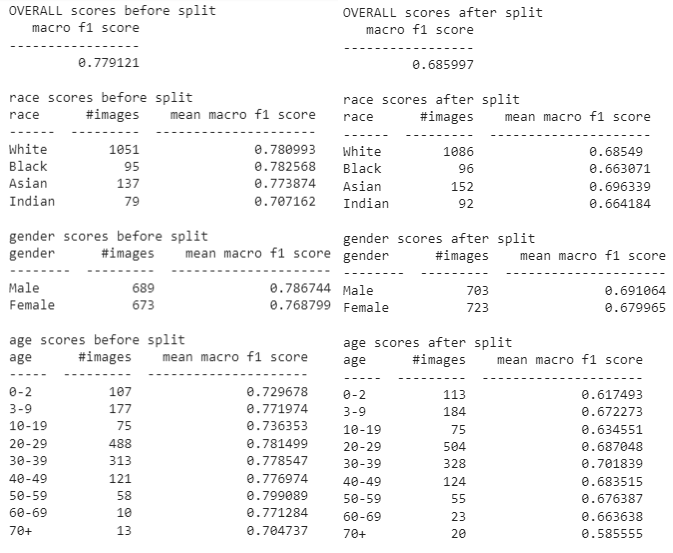

ΠΑΡΑΤΗΡΗΣΕΙΣ:
* το f1 score είναι καλύτερο ΠΡΙΝ το split
* για τις κατηγορίες AGE (60-69,70+) τα αποτελέσματα είναι καλύτερα και παρόμοια με τις αλλές κατηγοριες μετα το split

Παραμέτροι του μοντέλου <br>
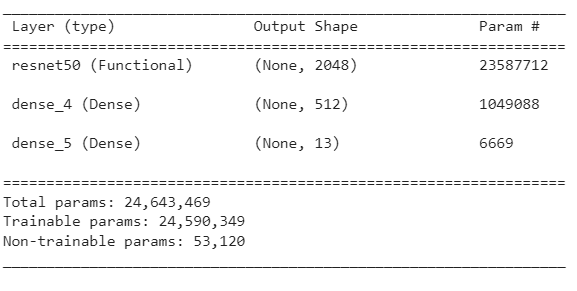

Υπερπαραμέτροι του μοντέλου <br>
* Optimizer: Adam
* Learning rate: 0.001
* Activation Function: Sigmoid
* Loss Function: Sigmoid Cross Entropy
* Epochs: 10